In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
# Load the dataset
data = pd.read_csv('dataset/PDB_Load_History.csv')
data['date'] = pd.to_datetime(data['date'])

# Select relevant columns
data = data[['date', 'demand', 'temperature']]

# Set date as index
data.set_index('date', inplace=True)

In [3]:
# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [4]:
# Function to create input and output sequences for time series data
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

In [5]:
# Define sequence length and split the data into train and test sets
sequence_length = 24  # Example: using 24 hours to predict the next hour
X, y = create_sequences(data_scaled, sequence_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 2)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [7]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
2594/2594 [==============================] - 52s 18ms/step - loss: 0.0040
Epoch 2/50
2594/2594 [==============================] - 48s 18ms/step - loss: 8.8438e-04
Epoch 3/50
2594/2594 [==============================] - 58s 23ms/step - loss: 6.5531e-04
Epoch 4/50
2594/2594 [==============================] - 76s 29ms/step - loss: 5.6689e-04
Epoch 5/50
2594/2594 [==============================] - 71s 27ms/step - loss: 4.8549e-04
Epoch 6/50
2594/2594 [==============================] - 64s 25ms/step - loss: 4.3787e-04
Epoch 7/50
2594/2594 [==============================] - 81s 31ms/step - loss: 4.0319e-04
Epoch 8/50
2594/2594 [==============================] - 70s 27ms/step - loss: 3.7302e-04
Epoch 9/50
2594/2594 [==============================] - 59s 23ms/step - loss: 3.5222e-04
Epoch 10/50
2594/2594 [==============================] - 53s 21ms/step - loss: 3.3419e-04
Epoch 11/50
2594/2594 [==============================] - 49s 19ms/step - loss: 3.2334e-04
Epoch 12/50
2594/2594 [

In [8]:
# Predict on test set
predicted = model.predict(X_test)

649/649 [==============================] - 6s 7ms/step


In [9]:
# Inverse transform predictions and actual values to their original scale
predicted = scaler.inverse_transform(np.concatenate((X_test[:, -1, 0].reshape(-1, 1), predicted), axis=1))[:, 1]
actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, 0].reshape(-1, 1), y_test.reshape(-1, 1)), axis=1))[:, 1]

In [10]:
# Calculate KPIs (e.g., RMSE)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.9350659047158175


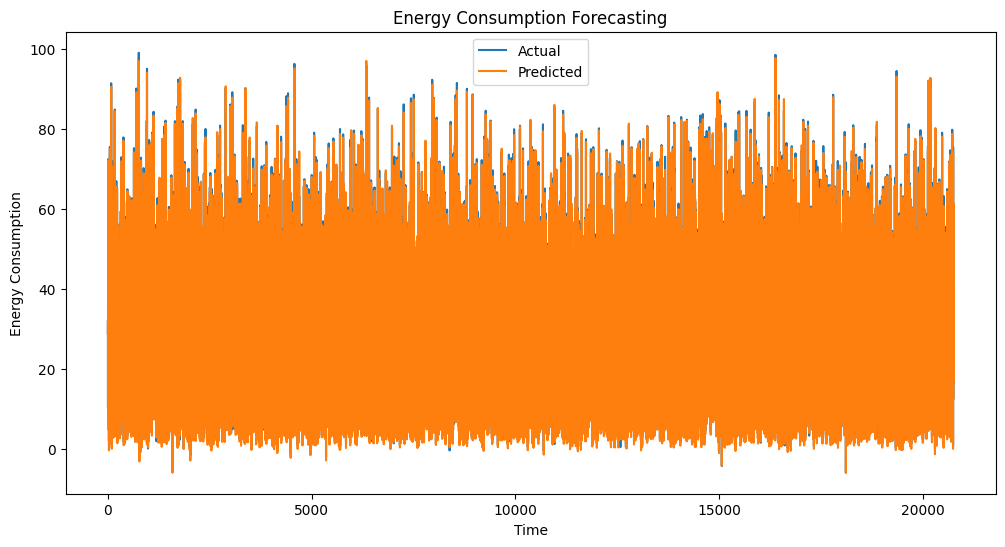

In [11]:
# Visualize the predictions vs. actual values
plt.figure(figsize=(12, 6))
plt.plot(actual, label='Actual')
plt.plot(predicted, label='Predicted')
plt.title('Energy Consumption Forecasting')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()